<a href="https://colab.research.google.com/github/jairomartinezgiraldo/CNN/blob/main/CNNVIERNES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Importar librerías necesarias
import os
from google.colab import files
from google.colab import drive
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # Importar los callbacks

In [27]:

# Descargar el dataset de Yoga desde Kaggle
!kaggle datasets download -d tr1gg3rtrash/yoga-posture-dataset

# Descomprimir el archivo descargado
import zipfile
with zipfile.ZipFile('yoga-posture-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/yoga_dataset')

print("Dataset descargado y extraído exitosamente.")


Dataset URL: https://www.kaggle.com/datasets/tr1gg3rtrash/yoga-posture-dataset
License(s): CC0-1.0
yoga-posture-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset descargado y extraído exitosamente.


In [28]:
# Primero, definimos dónde está nuestro conjunto de datos
base_dir = '/content/yoga_dataset'
drive.mount('/content/drive')
os.makedirs(base_dir, exist_ok=True)
os.makedirs(f"{base_dir}/results", exist_ok=True)
os.makedirs(f"{base_dir}/models", exist_ok=True)  # Carpeta para almacenar el mejor modelo


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
subfolders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
print(f"Total de clases: {len(subfolders)}")
print("Clases encontradas:", subfolders)

Total de clases: 49
Clases encontradas: ['Ardha Chandrasana', 'Dhanurasana', 'Pincha Mayurasana', 'Trikonasana', 'models', 'Eka Pada Rajakapotasana', 'Virabhadrasana Two', 'Sivasana', 'Utkatasana', 'Garudasana', 'Baddha Konasana', 'results', 'Salamba Bhujangasana', 'Halasana', 'Utthita Hasta Padangusthasana', 'Bakasana', 'Virabhadrasana Three', 'Navasana', 'Urdhva Dhanurasana', 'Setu Bandha Sarvangasana', 'Uttanasana', 'Padmasana', 'Adho Mukha Svanasana', 'Utthita Parsvakonasana', 'Ardha Pincha Mayurasana', 'Ashta Chandrasana', 'Urdhva Mukha Svsnssana', 'Camatkarasana', 'Malasana', 'Paschimottanasana', 'Parsvottanasana', 'Ustrasana', 'Balasana', 'Anjaneyasana', 'Vasisthasana', 'Ardha Navasana', 'Adho Mukha Vrksasana', 'Hanumanasana', 'Ardha Matsyendrasana', 'Vrksasana', 'Upavistha Konasana', 'Supta Kapotasana', 'Phalakasana', 'Virabhadrasana One', 'Salamba Sarvangasana', 'Marjaryasana', 'Bitilasana', 'Parsva Virabhadrasana', 'Alanasana']


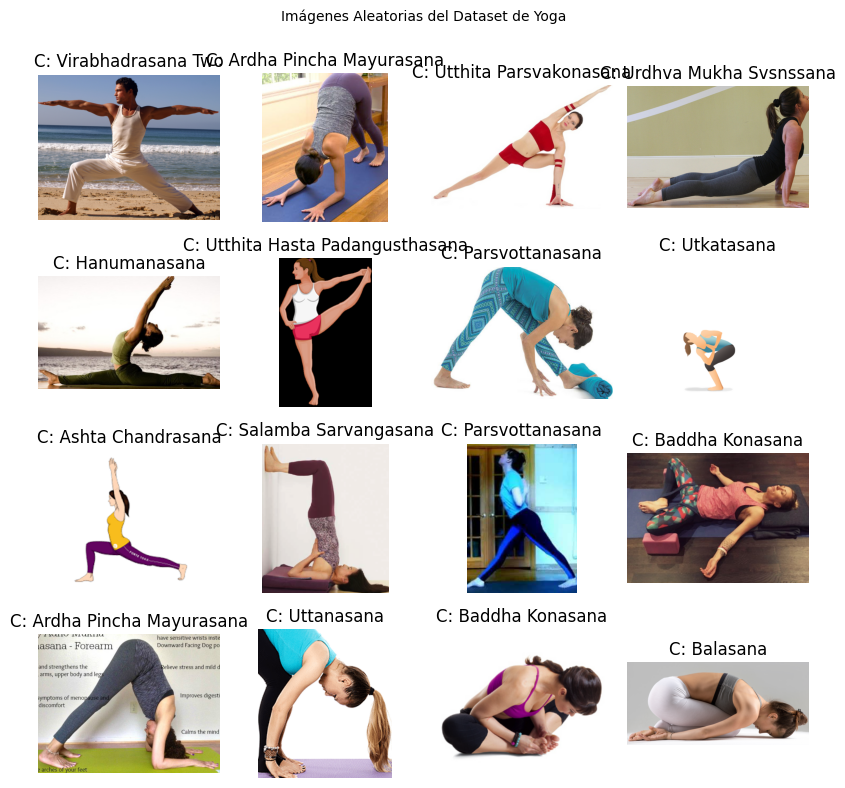

In [33]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Imágenes Aleatorias del Dataset de Yoga', fontsize=10)

for ax in axes.flatten():
    chosen_folder = np.random.choice(subfolders)
    subfolder_path = os.path.join(base_dir, chosen_folder)

    # Verificar que la carpeta contiene imágenes
    images = [img for img in os.listdir(subfolder_path) if img.endswith(('.png', '.jpeg', '.jpg'))]
    if not images:  # Si la carpeta está vacía o no tiene imágenes, salta esta iteración
        ax.set_title('Sin imágenes')
        ax.axis('off')
        continue

    # Seleccionar una imagen aleatoria
    img_name = np.random.choice(images)
    img_path = os.path.join(subfolder_path, img_name)

    # Leer y mostrar la imagen
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"C: {chosen_folder}")
    else:
        ax.set_title('Imagen no encontrada')
        ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Paso 3: Configuración de Generadores de Datos con Aumento de Datos
Para entrenar nuestra red de manera eficiente y mejorar su capacidad de generalización, usaremos Data Augmentation o aumento de datos. Esta técnica permite crear variaciones de las imágenes originales aplicando transformaciones como rotaciones, cambios de tamaño y espejado. De esta forma, la red "ve" más datos y puede aprender mejor.

In [41]:
## Paso 2: Configuración de ImageDataGenerator para Entrenamiento, Validación y Prueba

# Tamaño de imagen ajustado para MobileNetV2
IMG_SIZE = (224, 224)

# Configuración del aumento de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3  # Dividir el dataset en 70% entrenamiento y 30% (para validación y prueba)
)

# Generador de datos para el conjunto de entrenamiento (70% del total)
train_generator = train_datagen.flow_from_directory(
    '/content/yoga_dataset',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='training',
    color_mode='rgb'
)

# Generador de datos para el conjunto de validación (15% del total)
val_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.5)
val_generator = val_datagen.flow_from_directory(
    '/content/yoga_dataset',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb'
)

# Generador de datos para el conjunto de prueba (15% del total)
test_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.5)
test_generator = test_datagen.flow_from_directory(
    '/content/yoga_dataset',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb',
    shuffle=False  # Para mantener el orden de las clases
)

Found 1953 images belonging to 49 classes.
Found 1366 images belonging to 49 classes.
Found 1366 images belonging to 49 classes.


In [42]:
# Definir los callbacks para

model_path = '/content/drive/MyDrive/yoga_pose_classification/best_yoga_pose_model.keras'

# Early Stopping detiene el entrenamiento cuando la pérdida de validación deja de mejorar,
# evitando sobreajuste.

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
# Model Checkpointing guarda el mejor modelo,
# permitiendo recuperarlo para futuras predicciones o continuar el entrenamiento.

model_checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# ReduceLROnPlateau reduce la tasa de aprendizaje cuando el modelo deja de mejorar,
# ayudando al modelo a converger de manera más fina.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

Paso 4: Cargar una Red Preentrenada (Transfer Learning)
Aquí viene la parte interesante: Transfer Learning. Utilizaremos una red llamada MovilnetV2, que ya ha sido entrenada en millones de imágenes (de ImageNet). Esto significa que MovilnetV2 ya ha aprendido muchas características útiles para reconocer objetos. Nosotros aprovecharemos su "experiencia" y añadiremos nuestras propias capas finales para que pueda clasificar las posturas de yoga.

Nota: En este primer paso, no vamos a ajustar todas las capas; solo entrenaremos las capas que agregamos al final. Esto se llama "congelar" el modelo base.

In [43]:
# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar el modelo base para el primer entrenamiento

# Construir las capas adicionales para la clasificación
x = base_model.output
x = layers.Flatten()(x)  # Utilizar Flatten para conservar toda la información espacial
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(47, activation='softmax')(x)  # 47 clases de poses de yoga

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo con una tasa de aprendizaje inicial
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento inicial (solo las capas añadidas)
history_aug = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,  # Suficientes épocas para observar convergencia en Transfer Learning
    callbacks=callbacks
)

Epoch 1/15


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 49), output.shape=(None, 47)

In [15]:
# Evaluación en Transfer Learning
results_transfer = model.evaluate(test_generator, verbose=0)
print("    Test Loss (Transfer Learning): {:.5f}".format(results_transfer[0]))
print("Test Accuracy (Transfer Learning): {:.2f}%".format(results_transfer[1] * 100))

# Predicción y reporte de clasificación
predictions_transfer = model.predict(test_generator, batch_size=128)
print("Reporte de Clasificación - Transfer Learning:")
print(classification_report(test_generator.classes, predictions_transfer.argmax(axis=1), target_names=test_generator.class_indices.keys()))

    Test Loss (Transfer Learning): 4.12639
Test Accuracy (Transfer Learning): 65.30%
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step
Reporte de Clasificación - Transfer Learning:
                               precision    recall  f1-score   support

         Adho Mukha Svanasana       1.00      0.54      0.70        37
         Adho Mukha Vrksasana       1.00      0.19      0.32        32
                    Alanasana       0.75      0.33      0.46         9
                 Anjaneyasana       0.67      0.40      0.50        35
            Ardha Chandrasana       0.90      0.62      0.73        29
         Ardha Matsyendrasana       0.72      0.58      0.64        48
               Ardha Navasana       1.00      0.17      0.29         6
      Ardha Pincha Mayurasana       0.40      0.63      0.49        27
            Ashta Chandrasana       1.00      0.17      0.29         6
              Baddha Konasana       0.59      0.60      0.59        40
                     Bakasana       0.79     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


paso 5: Evaluación y Graficación de Métricas del Transfer Learning
Una vez completado el primer entrenamiento, evaluaremos las métricas de precisión y pérdida para ver cómo ha aprendido el modelo hasta ahora.

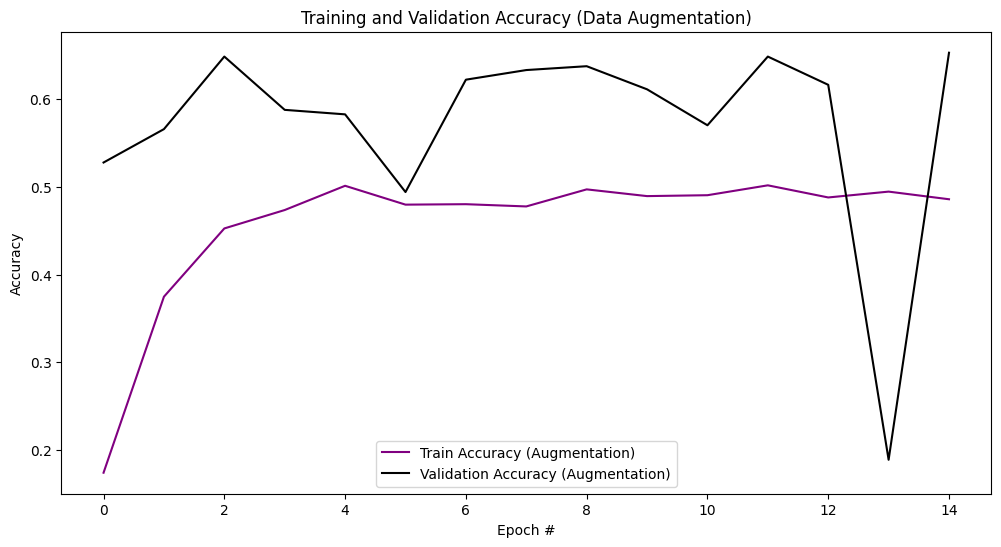

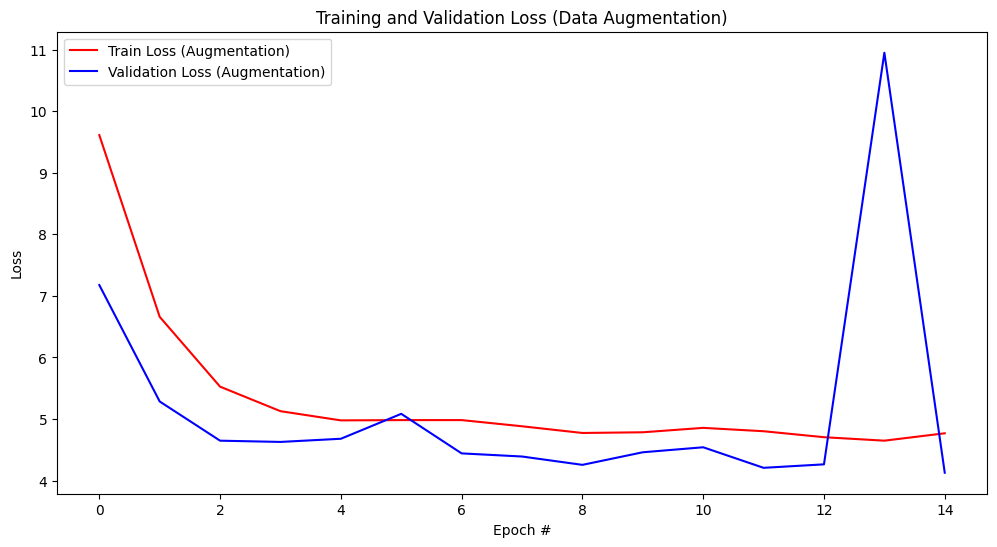

In [16]:
# Graficar Accuracy de entrenamiento y validación de Data Augmentation
plt.figure(figsize=(12, 6))
plt.plot(history_aug.history["accuracy"], label="Train Accuracy (Augmentation)", color='purple')
plt.plot(history_aug.history["val_accuracy"], label="Validation Accuracy (Augmentation)", color='black')
plt.title("Training and Validation Accuracy (Data Augmentation)")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# Graficar Loss de entrenamiento y validación de Data Augmentation
plt.figure(figsize=(12, 6))
plt.plot(history_aug.history["loss"], label="Train Loss (Augmentation)", color='red')
plt.plot(history_aug.history["val_loss"], label="Validation Loss (Augmentation)", color='blue')
plt.title("Training and Validation Loss (Data Augmentation)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()




Paso 6: Fine-Tuning del Modelo
Ahora vamos a realizar Fine-Tuning. Descongelaremos algunas capas de ResNet50 para que el modelo pueda ajustar mejor las características de alto nivel para nuestro conjunto de datos. Esto permite una especialización más profunda, pero hay que hacerlo con cuidado para evitar sobreajuste.

In [17]:
# Descongelar parcialmente el modelo base
fine_tune_at = 120  # Descongelar capas a partir de la capa 120

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
base_model.trainable = True

# Compilar el modelo nuevamente con una tasa de aprendizaje menor
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento con Fine-Tuning
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
42/62 ━━━━━━━━━━━━━━━━━━━━ 19s 998ms/step - accuracy: 0.3399 - loss: 5.2466

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.3540 - loss: 5.1366 - val_accuracy: 0.6142 - val_loss: 3.9939
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 611ms/step - accuracy: 0.5390 - loss: 4.0384 - val_accuracy: 0.7218 - val_loss: 3.3023
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 597ms/step - accuracy: 0.6372 - loss: 3.4243 - val_accuracy: 0.7570 - val_loss: 2.9203
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 590ms/step - accuracy: 0.7041 - loss: 3.0294 - val_accuracy: 0.7584 - val_loss: 2.7289
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 594ms/step - accuracy: 0.7287 - loss: 2.7311 - val_accuracy: 0.7416 - val_loss: 2.6375
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 603ms/step - accuracy: 0.7744 - loss: 2.4447 - val_accuracy: 0.7840 - val_loss: 2.3078
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 590ms/step - accuracy: 0.8102 - loss: 2.1917 - val_accuracy: 0.7833 - val_loss: 2.1650
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 593ms/step - accuracy: 0.8489 - loss: 1.9328 - val_accuracy: 0.8155 

In [18]:
# Evaluación en Fine-Tuning
results_fine_tuning = model.evaluate(test_generator, verbose=0)
print("    Test Loss (Fine-Tuning): {:.5f}".format(results_fine_tuning[0]))
print("Test Accuracy (Fine-Tuning): {:.2f}%".format(results_fine_tuning[1] * 100))

# Predicción y reporte de clasificación en Fine-Tuning
predictions_fine = model.predict(test_generator, batch_size=128)
print("Reporte de Clasificación - Fine-Tuning:")
print(classification_report(test_generator.classes, predictions_fine.argmax(axis=1), target_names=test_generator.class_indices.keys()))


    Test Loss (Fine-Tuning): 1.73031
Test Accuracy (Fine-Tuning): 83.24%
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 243ms/step
Reporte de Clasificación - Fine-Tuning:
                               precision    recall  f1-score   support

         Adho Mukha Svanasana       0.95      0.54      0.69        37
         Adho Mukha Vrksasana       0.88      0.44      0.58        32
                    Alanasana       0.38      0.67      0.48         9
                 Anjaneyasana       0.78      0.83      0.81        35
            Ardha Chandrasana       0.83      1.00      0.91        29
         Ardha Matsyendrasana       0.97      0.79      0.87        48
               Ardha Navasana       0.75      0.50      0.60         6
      Ardha Pincha Mayurasana       0.69      0.81      0.75        27
            Ashta Chandrasana       1.00      0.17      0.29         6
              Baddha Konasana       0.72      0.85      0.78        40
                     Bakasana       0.90      0.88      0.89   

Paso 7: Evaluación y Graficación de Métricas con Fine-Tuning

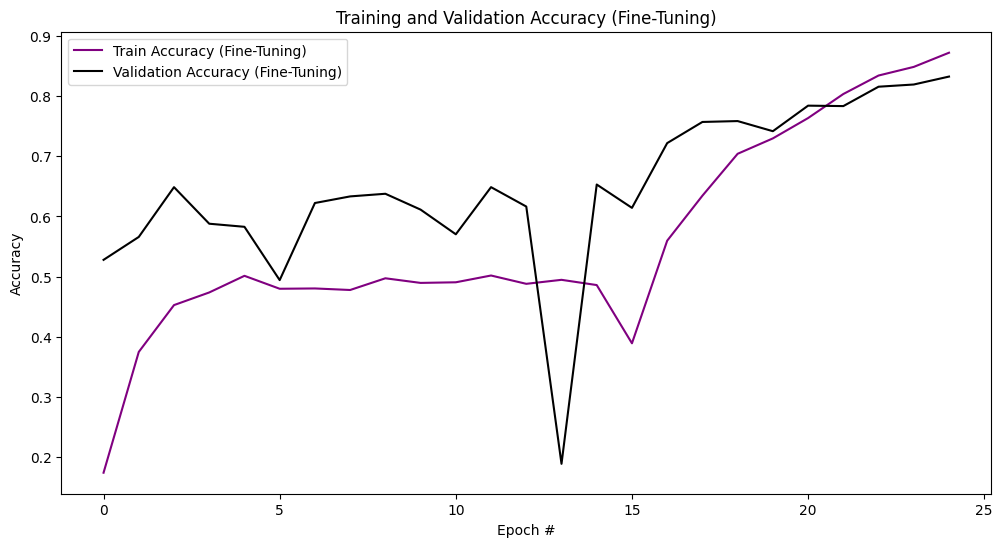

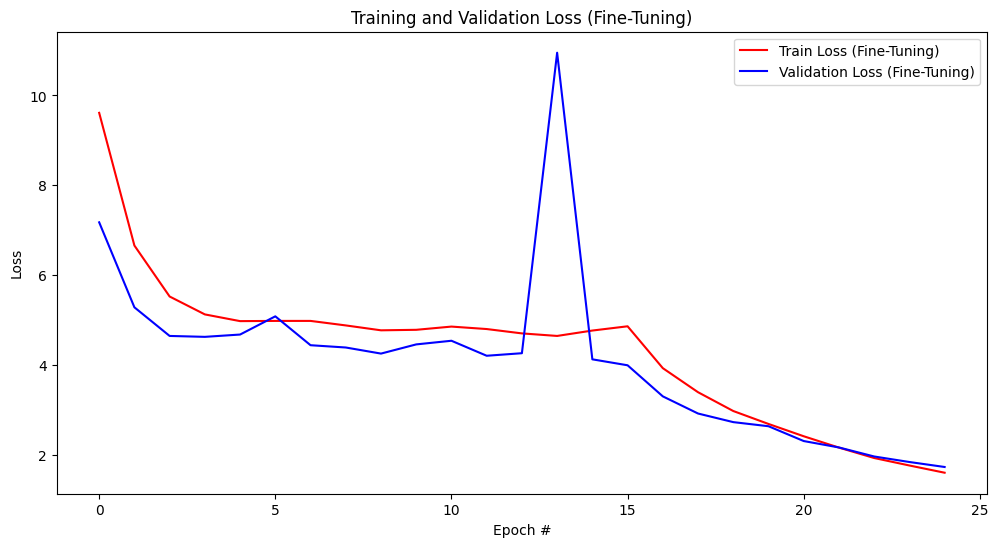

In [19]:
# Graficar Accuracy de entrenamiento y validación de Fine-Tuning


acc = history_aug.history['accuracy'] + history_fine.history['accuracy']
val_acc = history_aug.history['val_accuracy'] + history_fine.history['val_accuracy']
plt.figure(figsize=(12, 6))
plt.plot(range(len(acc)), acc, label='Train Accuracy (Fine-Tuning)', color='purple')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy (Fine-Tuning)', color='black')
plt.title("Training and Validation Accuracy (Fine-Tuning)")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# Graficar Loss de entrenamiento y validación de Fine-Tuning
loss = history_aug.history['loss'] + history_fine.history['loss']
val_loss = history_aug.history['val_loss'] + history_fine.history['val_loss']
plt.figure(figsize=(12, 6))
plt.plot(range(len(loss)), loss, label='Train Loss (Fine-Tuning)', color='red')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss (Fine-Tuning)', color='blue')
plt.title("Training and Validation Loss (Fine-Tuning)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()